In [1]:
# !pip install transformers
# !pip install keras_nlp
# !pip install datasets
# !pip install huggingface-hub huggingface_hub
# !pip install nltk
# !pip install rouge-score rouge
# !pip install evaluate
# !apt install git-lfs

In [2]:
# from huggingface_hub import notebook_login

# notebook_login()

In [3]:
!git config --global user.email "oabass7@gmail.com"
!git config --global user.name "Jammal"

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from datasets import load_dataset, load_metric, load_from_disk
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, AdamWeightDecay, create_optimizer 
from transformers.keras_callbacks import  KerasMetricCallback
import evaluate
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

# Only log error messages
import logging
tf.get_logger().setLevel(logging.ERROR)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading the dataset

### About Dataset
[BIGPATENT](https://huggingface.co/datasets/big_patent), consisting of 1.3 million records of U.S. patent documents along with human written abstractive summaries. Each US patent application is filed under a Cooperative Patent Classification (CPC) code. There are nine such classification categories:

* a: Human Necessities
* b: Performing Operations; Transporting
* c: Chemistry; Metallurgy
* **d: Textiles; Paper**
* e: Fixed Constructions
* f: Mechanical Engineering; Lightning; Heating; Weapons; Blasting
* g: Physics
* h: Electricity
* y: General tagging of new or cross-sectional technology

I will be working with 1 out of the 9 classification categories due to low compute unit.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# df = load_dataset("big_patent", "d")

In [7]:
# saving the data
# df.to_csv('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d.csv', index=False)
# df.save_to_disk('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d_dataset')

In [8]:
df = load_from_disk('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d_dataset')
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 10164
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


In [9]:
df['train'] = df['train'].shuffle(seed=42).select(range(1000))

In [10]:
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


### Define Certain Variables

In [11]:
# Maximum length of the input to the model
MAX_INPUT_LENGTH = 1024  

# Minimum length of the output by the model
MIN_TARGET_LENGTH = 5  
# Maximum length of the output by the model
MAX_TARGET_LENGTH = 512 

# Batch-size for training our model
BATCH_SIZE = 16

## T5 Model

#### Data preprocessing

In [12]:
MODEL_CHECKPOINT = "t5-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

if MODEL_CHECKPOINT in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [13]:
def preprocess_function(examples):
    inputs = [prefix + inp for inp in examples["description"]]
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)
    targets = examples["abstract"]

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [14]:
tokenized_df = df.map(preprocess_function, batched=True)

In [15]:
tokenized_df["train"]

Dataset({
    features: ['description', 'abstract', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

### Fine-tuning the Model

In [16]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [17]:
# pushing the model to tensorflow hub
model_name = MODEL_CHECKPOINT.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-Big-Patent"

In [18]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")
generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)

In [19]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_df["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_df["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
)

tf_generation_set = model.prepare_tf_dataset(
    tokenized_df["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=generation_data_collator
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### Compiling the Model

In [20]:
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01) 
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


### Evaluate the Model

In [21]:
metric = load_metric("rouge")

def metric_fn(eval_predictions):
    predictions, labels = eval_predictions
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]
    result = metric.compute(
        predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result

In [22]:
from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="./summarization_model_save/logs")

push_to_hub_callback = PushToHubCallback(
    output_dir="./summarization_model_save",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
)

/content/summarization_model_save is already a clone of https://huggingface.co/Jammal7/t5-small-finetuned-Big-Patent. Make sure you pull the latest changes with `repo.git_pull()`.


### Train the Model

In [23]:
metric_callback = KerasMetricCallback(
    metric_fn, eval_dataset=tf_generation_set, predict_with_generate=True, use_xla_generation=True
)

callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]

history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=15, callbacks=callbacks)

Epoch 1/15
62/62 [==============================] - 1214s 19s/step - loss: 3.7404 - val_loss: 2.9790 - rouge1: 16.0861 - rouge2: 6.3337 - rougeL: 13.0572 - rougeLsum: 14.1865 - gen_len: 19.0000
Epoch 2/15
62/62 [==============================] - 1160s 19s/step - loss: 3.0790 - val_loss: 2.7949 - rouge1: 16.4660 - rouge2: 6.8110 - rougeL: 13.2669 - rougeLsum: 14.5150 - gen_len: 19.0000
Epoch 3/15
62/62 [==============================] - 1174s 19s/step - loss: 2.9258 - val_loss: 2.6986 - rouge1: 16.3790 - rouge2: 6.7593 - rougeL: 13.1858 - rougeLsum: 14.4023 - gen_len: 19.0000
Epoch 4/15
62/62 [==============================] - 1178s 19s/step - loss: 2.8443 - val_loss: 2.6371 - rouge1: 16.6141 - rouge2: 6.9854 - rougeL: 13.3944 - rougeLsum: 14.6000 - gen_len: 19.0000
Epoch 5/15
62/62 [==============================] - 1173s 19s/step - loss: 2.7807 - val_loss: 2.5929 - rouge1: 17.2393 - rouge2: 7.4286 - rougeL: 13.7774 - rougeLsum: 15.1535 - gen_len: 19.0000
Epoch 6/15
62/62 [============

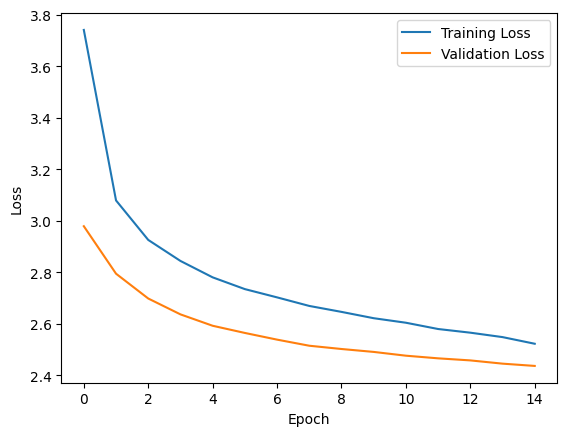

In [24]:
# Plot the metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained("Jammal7/t5-small-finetuned-Big-Patent")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Jammal7/t5-small-finetuned-Big-Patent.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [26]:
# # Save the model in SavedModel format
# model.save_pretrained("/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/t5_model")

### Test the model

In [28]:
# Assign the model path to model_name
model_name = "Jammal7/t5-small-finetuned-Big-Patent"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Jammal7/t5-small-finetuned-Big-Patent.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [34]:
df['test'][0]['description']

'CROSS-REFERENCE TO RELATED APPLICATIONS \n     The present application claims priority from Australian Provisional Patent Application No 2006903417 filed on 26 Jun. 2006, the content of which is incorporated herein by reference. \n     INTRODUCTION TO THE INVENTION \n     This invention relates to the packaging of consumer products and relates particularly to products that are formed of pulp material, particularly pulp material formed of waste paper, waste timber, waste fabric material, virgin timber and other similar pulp material. The invention more particularly relates to high quality products carrying high definition printing or other decoration. \n     BACKGROUND TO THE INVENTION \n     The creation of compelling and high quality packaging for consumer durables is well established and is executed in a variety of forms and formats known in the prior art but with each of the prior art, the formats and methodologies having their own particular limitations. The consumer market demand

In [29]:
document = df['test'][0]['description']
if 't5' in model_name: 
    document = "summarize: " + document

In [30]:
tokenized = tokenizer([document], return_tensors='np')
out = model.generate(**tokenized, max_length=128)
with tokenizer.as_target_tokenizer():
    print(tokenizer.decode(out[0]))

Token indices sequence length is longer than the specified maximum sequence length for this model (8952 > 512). Running this sequence through the model will result in indexing errors


<pad> A pre-form is preferably a pre-form, which is preferably a pre-form, and is subsequently deposited into the pre-form. The pre-form is preferably a pre-form, which is preferably a pre-form, and is subsequently disposed in the pre-form. The pre-form is preferably a pre-form, which is preferably a pre-form, and is disposed in a pre-form, and is disposed in a pre-form form of the pre-form, and the slurry is


In [31]:
tokenized = tokenizer([document], return_tensors='tf')
out = model.generate(input_ids=tokenized.input_ids, attention_mask=tokenized.attention_mask, max_length=128)
summary = tokenizer.decode(out[0])

print("Summary:")
print(summary)

Summary:
<pad> A pre-form is preferably a pre-form, which is preferably a pre-form, and is subsequently deposited into the pre-form. The pre-form is preferably a pre-form, which is preferably a pre-form, and is subsequently disposed in the pre-form. The pre-form is preferably a pre-form, which is preferably a pre-form, and is disposed in a pre-form, and is disposed in a pre-form form of the pre-form, and the slurry is


In [32]:
df['test'][0]['abstract']

'A method of forming a moulded and printed product from pulp material including the steps of: forming a pre-form mould to have one or more planar surfaces, compound conjoined planar surfaces and/or two dimensional curved surfaces; transferring an amount of pulp slurry material to the pre-form mould; forming a moulded pre-form from the transferred pulp slurry material; applying printing to the planar and/or dimensional curved surfaces in a pre-distorted configuration; and moulding the printed pre-form to a different final shape whereby the printed surfaces retain the printing without running and the printing conforms to a desired post distortion configuration.'

## MT5 Model

## BART Model

## PEGASUS Model

## GP2 Model